In [16]:
from __future__ import annotations
import math
import random
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Tuple

import pandas as pd

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import BatchSampler
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt



In [17]:
def set_seed(seed: int = 42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [18]:
class ReviewDataset(Dataset):
    """Review-level dataset.
    Expects:
      texts: list[str]
      y_quality: list[int] in {0,1,2}  (Low, Med, Good)
      y_relevance: list[int] in {0,1}  (Irrelevant, Relevant)
    Optional meta features (precomputed):
      meta: [N, D] float
    """

    def __init__(
        self,
        texts: List[str],
        y_quality: List[int],
        y_relevance: List[int],
        tokenizer: AutoTokenizer,
        max_len: int = 128,
        meta: Optional[np.ndarray] = None,
    ):
        assert len(texts) == len(y_quality) == len(y_relevance)
        self.texts = texts
        self.yq = np.asarray(y_quality, dtype=np.int64)
        self.yr = np.asarray(y_relevance, dtype=np.int64)
        self.tok = tokenizer
        self.max_len = max_len
        self.meta = meta

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i: int):
        enc = self.tok(self.texts[i], truncation=True, padding="max_length", max_length=self.max_len)
        item = {k: torch.tensor(v) for k, v in enc.items()}
        item["yq"] = torch.tensor(int(self.yq[i]))
        item["yr"] = torch.tensor(int(self.yr[i]))
        if self.meta is not None:
            item["meta"] = torch.tensor(self.meta[i], dtype=torch.float32)
        return item

In [19]:
class BalancedBatchSampler(BatchSampler):
    """
    Ensures each batch contains C distinct QUALITY classes with S samples each.
    Batch size = C * S. Positives for SupCon are guaranteed in-batch.
    """
    def __init__(self, labels: Iterable[int], classes_per_batch: int, samples_per_class: int, drop_last: bool = True):
        self.labels = np.asarray(list(labels), dtype=np.int64)
        self.classes_per_batch = int(classes_per_batch)
        self.samples_per_class = int(samples_per_class)
        self.drop_last = drop_last

        self.pool: Dict[int, List[int]] = {}
        for idx, c in enumerate(self.labels):
            self.pool.setdefault(int(c), []).append(idx)
        for c in self.pool:
            random.shuffle(self.pool[c])

        usable = sum(len(v) // self.samples_per_class for v in self.pool.values())
        self._len = max(usable // self.classes_per_batch, 0)

    def __len__(self):
        return self._len

    def __iter__(self):
        pools = {c: idxs.copy() for c, idxs in self.pool.items()}
        while True:
            avail = [c for c, idxs in pools.items() if len(idxs) >= self.samples_per_class]
            if len(avail) < self.classes_per_batch:
                break
            chosen = random.sample(avail, self.classes_per_batch)
            batch = []
            for c in chosen:
                take = [pools[c].pop() for _ in range(self.samples_per_class)]
                batch.extend(take)
            yield batch

In [20]:
class MeanPooler(nn.Module):
    def forward(self, last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        mask = attention_mask.unsqueeze(-1).float()  # [B,T,1]
        summed = (last_hidden_state * mask).sum(dim=1)
        denom = mask.sum(dim=1).clamp(min=1e-9)
        return summed / denom


class ReviewMTL(nn.Module):
    def __init__(self, encoder_name: str, n_quality: int = 3, n_relevance: int = 2, proj_dim: int = 256, dropout: float = 0.1, meta_dim: int = 0):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        self.pool = MeanPooler()
        H = self.encoder.config.hidden_size

        # Projection head for contrastive space
        self.proj = nn.Sequential(
            nn.Linear(H, H), nn.GELU(), nn.Dropout(dropout), nn.Linear(H, proj_dim)
        )

        # Optional meta pathway (concat features after pooling)
        self.meta_bn = nn.BatchNorm1d(meta_dim) if meta_dim > 0 else None
        head_in = H + (meta_dim if meta_dim > 0 else 0)

        # Two classifier heads
        self.head_quality = nn.Sequential(nn.Dropout(dropout), nn.Linear(head_in, n_quality))
        self.head_relev  = nn.Sequential(nn.Dropout(dropout), nn.Linear(head_in, n_relevance))

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, meta: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        emb = self.pool(out.last_hidden_state, attention_mask)  # [B,H]
        z = nn.functional.normalize(self.proj(emb), p=2, dim=-1)  # [B,D]
        if meta is not None and meta.numel() > 0:
            if self.meta_bn is not None:
                meta = self.meta_bn(meta)
            emb = torch.cat([emb, meta], dim=1)
        q_logits = self.head_quality(emb)
        r_logits = self.head_relev(emb)
        return z, q_logits, r_logits


In [21]:
def supcon_loss(z: torch.Tensor, y: torch.Tensor, temperature: float = 0.07) -> torch.Tensor:
    """Supervised Contrastive loss (InfoNCE over in-batch positives)."""
    B = z.size(0)
    sim = (z @ z.t()) / temperature  # cosine if z normalized
    eye = torch.eye(B, device=z.device, dtype=torch.bool)
    sim.masked_fill_(eye, -1e9)
    pos = (y.unsqueeze(0) == y.unsqueeze(1)) & (~eye)
    log_denom = torch.logsumexp(sim, dim=1, keepdim=True)
    log_prob = sim - log_denom
    pos_counts = pos.sum(dim=1).clamp(min=1)
    loss_per = -(log_prob * pos).sum(dim=1) / pos_counts
    return loss_per.mean()


def ce_smooth_weighted(logits: torch.Tensor, targets: torch.Tensor, n_classes: int, smoothing: float = 0.0, class_weight: Optional[torch.Tensor] = None) -> torch.Tensor:
    """Cross-entropy with label smoothing and optional per-class weights."""
    if smoothing <= 0.0 and class_weight is None:
        return nn.functional.cross_entropy(logits, targets)
    with torch.no_grad():
        true = torch.zeros_like(logits)
        true.fill_(smoothing / (n_classes - 1))
        true.scatter_(1, targets.unsqueeze(1), 1.0 - smoothing)
    logp = nn.functional.log_softmax(logits, dim=-1)
    loss_per = -(true * logp).sum(dim=1)
    if class_weight is not None:
        w = class_weight[targets]
        loss_per = loss_per * w
        return loss_per.sum() / w.sum().clamp(min=1e-9)
    return loss_per.mean()


def balanced_class_weights(labels: np.ndarray, n_classes: int) -> np.ndarray:
    counts = np.bincount(labels, minlength=n_classes).astype(float)
    counts[counts == 0.0] = 1.0
    total = counts.sum()
    return total / (n_classes * counts)

In [22]:
@dataclass
class TrainConfig:
    encoder_name: str = "BAAI/bge-m3"
    max_len: int = 128
    classes_per_batch: int = 6
    samples_per_class: int = 4  # batch = C × S
    epochs_contrastive: int = 2
    epochs_joint: int = 4
    lr_encoder: float = 2e-5
    lr_heads: float = 2e-4
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    label_smoothing: float = 0.05
    lambda_contrastive: float = 0.1
    temperature: float = 0.07
    use_class_weights: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


def build_model_and_tok(n_quality: int, n_relevance: int, meta_dim: int, cfg: TrainConfig):
    tok = AutoTokenizer.from_pretrained(cfg.encoder_name, use_fast=True)
    model = ReviewMTL(cfg.encoder_name, n_quality=n_quality, n_relevance=n_relevance, meta_dim=meta_dim).to(cfg.device)
    return model, tok


def make_train_loader(train_ds: ReviewDataset, cfg: TrainConfig):
    sampler = BalancedBatchSampler(train_ds.yq, cfg.classes_per_batch, cfg.samples_per_class, drop_last=True)
    return DataLoader(train_ds, batch_sampler=sampler)


def make_val_loader(val_ds: ReviewDataset, cfg: TrainConfig):
    bs = cfg.classes_per_batch * cfg.samples_per_class
    return DataLoader(val_ds, batch_size=bs, shuffle=False)


def make_optimizers(model: ReviewMTL, cfg: TrainConfig, total_steps: int):
    param_groups = [
        {"params": list(model.encoder.parameters()), "lr": cfg.lr_encoder, "weight_decay": cfg.weight_decay},
        {"params": list(model.proj.parameters()) + list(model.head_quality.parameters()) + list(model.head_relev.parameters()),
         "lr": cfg.lr_heads, "weight_decay": 0.0},
    ]
    opt = torch.optim.AdamW(param_groups)
    sched = get_linear_schedule_with_warmup(opt, int(cfg.warmup_ratio * total_steps), total_steps)
    return opt, sched


@torch.no_grad()
def evaluate(model: ReviewMTL, val_dl: DataLoader, cfg: TrainConfig) -> Tuple[float, float, float]:
    model.eval()
    yq_t, yq_p, yr_t, yr_p = [], [], [], []
    for b in val_dl:
        meta = b.get("meta")
        meta = meta.to(cfg.device) if isinstance(meta, torch.Tensor) else None
        z, q, r = model(b["input_ids"].to(cfg.device), b["attention_mask"].to(cfg.device), meta=meta)
        yq_t += b["yq"].tolist(); yr_t += b["yr"].tolist()
        yq_p += q.argmax(-1).cpu().tolist()
        yr_p += r.argmax(-1).cpu().tolist()
    f1_q = f1_score(yq_t, yq_p, average="macro")
    f1_r = f1_score(yr_t, yr_p, average="macro")
    exact = np.mean((np.array(yq_t)==np.array(yq_p)) & (np.array(yr_t)==np.array(yr_p)))
    return f1_q, f1_r, exact


In [23]:
def train_model(train_ds: ReviewDataset, val_ds: ReviewDataset, n_quality: int, n_relevance: int, cfg: TrainConfig = TrainConfig()):
    set_seed(42)
    meta_dim = (train_ds.meta.shape[1] if train_ds.meta is not None else 0)
    model, _ = build_model_and_tok(n_quality, n_relevance, meta_dim=meta_dim, cfg=cfg)
    train_dl = make_train_loader(train_ds, cfg)
    val_dl = make_val_loader(val_ds, cfg)

    # Optional class weights
    wq = wr = None
    if cfg.use_class_weights:
        wq_np = balanced_class_weights(train_ds.yq, n_quality)
        wr_np = balanced_class_weights(train_ds.yr, n_relevance)
        wq = torch.tensor(wq_np, dtype=torch.float32, device=cfg.device)
        wr = torch.tensor(wr_np, dtype=torch.float32, device=cfg.device)

    scaler = torch.cuda.amp.GradScaler(enabled=(cfg.device == "cuda"))

    # -------- Stage 1: Contrastive warm-up on QUALITY --------
    steps_c = len(train_dl) * cfg.epochs_contrastive
    opt_c, sched_c = make_optimizers(model, cfg, total_steps=steps_c)
    for ep in range(cfg.epochs_contrastive):
        model.train()
        running, seen = 0.0, 0
        for b in train_dl:
            opt_c.zero_grad(set_to_none=True)
            with torch.autocast(device_type=("cuda" if cfg.device=="cuda" else "cpu"), dtype=torch.float16, enabled=(cfg.device=="cuda")):
                meta = b.get("meta")
                meta = meta.to(cfg.device) if isinstance(meta, torch.Tensor) else None
                z, _, _ = model(b["input_ids"].to(cfg.device), b["attention_mask"].to(cfg.device), meta=meta)
                Jc = supcon_loss(z, b["yq"].to(cfg.device), temperature=cfg.temperature)
            scaler.scale(Jc).backward()
            scaler.step(opt_c); scaler.update(); sched_c.step()
            running += Jc.item() * z.size(0); seen += z.size(0)
        print(f"[Warm-up {ep+1}/{cfg.epochs_contrastive}] SupCon={running/seen:.4f}")

    # -------- Stage 2: Joint training (CE + λ*SupCon) --------
    steps_j = len(train_dl) * cfg.epochs_joint
    opt, sched = make_optimizers(model, cfg, total_steps=steps_j)

    best_score, best_state = -1.0, None
    for ep in range(cfg.epochs_joint):
        model.train()
        running, seen = 0.0, 0
        for b in train_dl:
            opt.zero_grad(set_to_none=True)
            with torch.autocast(device_type=("cuda" if cfg.device=="cuda" else "cpu"), dtype=torch.float16, enabled=(cfg.device=="cuda")):
                meta = b.get("meta")
                meta = meta.to(cfg.device) if isinstance(meta, torch.Tensor) else None
                z, q_logits, r_logits = model(b["input_ids"].to(cfg.device), b["attention_mask"].to(cfg.device), meta=meta)

                # Hard-label losses
                Jq = ce_smooth_weighted(q_logits, b["yq"].to(cfg.device), n_classes=n_quality, smoothing=cfg.label_smoothing, class_weight=wq)
                Jr = ce_smooth_weighted(r_logits, b["yr"].to(cfg.device), n_classes=n_relevance, smoothing=0.0, class_weight=wr)
                Jc = supcon_loss(z, b["yq"].to(cfg.device), temperature=cfg.temperature)
                loss = Jq + Jr + cfg.lambda_contrastive * Jc

            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update(); sched.step()
            running += loss.item() * q_logits.size(0); seen += q_logits.size(0)

        f1_q, f1_r, exact = evaluate(model, val_dl, cfg)
        score = 0.6 * f1_q + 0.4 * f1_r
        print(f"[Joint {ep+1}/{cfg.epochs_joint}] loss={running/seen:.4f}  F1q={f1_q:.3f}  F1r={f1_r:.3f}  exact={exact:.3f}")

        if score > best_score:
            best_score = score
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


# -------------------------------------------------------
# Inference helper
# -------------------------------------------------------
@torch.no_grad()
def predict_proba(model: ReviewMTL, tokenizer: AutoTokenizer, texts: List[str], cfg: TrainConfig) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    all_q, all_r = [], []
    for i in range(0, len(texts), 64):
        batch = texts[i : i + 64]
        enc = tokenizer(batch, truncation=True, padding=True, max_length=cfg.max_len, return_tensors="pt")
        z, q, r = model(enc["input_ids"].to(cfg.device), enc["attention_mask"].to(cfg.device))
        all_q.append(q.softmax(-1).cpu().numpy())
        all_r.append(r.softmax(-1).cpu().numpy())
    return np.vstack(all_q), np.vstack(all_r)


In [24]:
XLSX_PATH = "labelled_dataset.xlsx"
df = pd.read_excel(XLSX_PATH, sheet_name=0)

In [25]:
print(df.columns)
reviews_and_labels_df = df.copy() 
reviews_and_labels_df = reviews_and_labels_df[['reviewText', 'qualityLevel', 'isRevelant']]

Index(['locationName', 'category', 'reviewerName', 'publishedAtDate', 'rating',
       'reviewText', 'Unnamed: 6', 'reviewImageUrls/0', 'reviewImageUrls/1',
       'reviewImageUrls/2', 'reviewImageUrls/3', 'reviewImageUrls/4',
       'reviewImageUrls/5', 'reviewImageUrls/6', 'reviewImageUrls/7',
       'reviewImageUrls/8', 'reviewImageUrls/9', 'reviewImageUrls/10',
       'reviewImageUrls/11', 'reviewImageUrls/12', 'reviewImageUrls/13',
       'reviewImageUrls/14', 'reviewImageUrls/15', 'reviewImageUrls/16',
       'reviewImageUrls/17', 'reviewImageUrls/18', 'reviewImageUrls/19',
       'reviewImageUrls/20', 'reviewImageUrls/21', 'reviewImageUrls/22',
       'reviewImageUrls/23', 'reviewImageUrls/24', 'reviewImageUrls/25',
       'reviewImageUrls/26', 'reviewImageUrls/27', 'reviewImageUrls/28',
       'reviewImageUrls/29', 'reviewImageUrls/30', 'reviewImageUrls/31',
       'reviewImageUrls/32', 'reviewImageUrls/33', 'reviewImageUrls/34',
       'reviewImageUrls/35', 'reviewImageUrls/36

In [26]:
def normalize_levels(series: pd.Series) -> pd.Series:
    cleaned = series.astype(str).str.lower().str.strip()
    mapping = {
        "low": "low", "Low": "low", 0: "low", "0": "low", "low ": "low",
        "medium": "medium", "med": "medium", 1: "medium", "1": "medium", 'medium ': 'medium', 'hmed': 'medium',
        "high": "high", "High": "high", 2: "high", "2": "high", 'higih': 'high', 'high ': 'high'
    }
    return cleaned.map(mapping)

In [27]:
reviews_and_labels_df["qualityLevel"] = normalize_levels(reviews_and_labels_df["qualityLevel"])


In [28]:
print(reviews_and_labels_df["qualityLevel"].unique())
print(reviews_and_labels_df['isRevelant'].unique())

['high' 'medium' 'low' nan]
[ 1.  0. nan]


In [29]:
reviews_and_labels_df = reviews_and_labels_df.dropna(subset=["qualityLevel", "isRevelant"])


In [30]:
q_map = {"low":0, "medium":1, "high":2}
def to_quality_id(v):
    # already numeric 0/1/2?
    if pd.api.types.is_number(v):
        vi = int(v)
        if vi in (0,1,2): return vi
    # string?
    s = str(v).strip().lower()
    if s in q_map: return q_map[s]
    # common numeric encodings
    if s in {"1","2","3"}: return {"1":0, "2":1, "3":2}[s]
    raise ValueError(f"Unrecognized qualityLevel value: {v!r}")

def to_rel_id(v):
    # bool / number
    if isinstance(v, (bool, np.bool_)): return int(v)
    if pd.api.types.is_number(v): return int(float(v) >= 0.5)
    # string
    s = str(v).strip().lower()
    if s in {"1","true","yes","relevant"}: return 1
    if s in {"0","false","no","irrelevant"}: return 0
    # fallback: anything non-empty counts as relevant? safer to be strict:
    return 0

In [31]:
# Use your DataFrame as given:
df = reviews_and_labels_df.copy()
assert {"reviewText","qualityLevel","isRevelant"} <= set(df.columns)

# Clean/convert labels
df = df.dropna(subset=["reviewText","qualityLevel","isRevelant"]).copy()
df["reviewText"] = df["reviewText"].astype(str)

df["yq"] = df["qualityLevel"].apply(to_quality_id).astype(int)   # 0/1/2
df["yr"] = df["isRevelant"].apply(to_rel_id).astype(int)         # 0/1

# Split (stratify by quality for balanced batches)
train_df, val_df = train_test_split(
    df, test_size=0.15, random_state=42, stratify=df["yq"]
)

ENCODER = "sentence-transformers/all-MiniLM-L6-v2"
tok = AutoTokenizer.from_pretrained(ENCODER, use_fast=True)

train_ds = ReviewDataset(
    texts=train_df["reviewText"].tolist(),
    y_quality=train_df["yq"].tolist(),
    y_relevance=train_df["yr"].tolist(),
    tokenizer=tok,
    max_len=128,     # short reviews -> 128 is plenty
    # meta=None      # omitted -> text-only
)
val_ds = ReviewDataset(
    texts=val_df["reviewText"].tolist(),
    y_quality=val_df["yq"].tolist(),
    y_relevance=val_df["yr"].tolist(),
    tokenizer=tok,
    max_len=128
)


In [32]:
cfg = TrainConfig(
    encoder_name=ENCODER,
    max_len=128,
    classes_per_batch=6,   # miner: 6 classes × 4 samples = batch 24
    samples_per_class=4,
    epochs_contrastive=2,  # SupCon on quality
    epochs_joint=4,        # CE(quality)+CE(relevance)+λ*SupCon
    lambda_contrastive=0.1,
    label_smoothing=0.05,
    use_class_weights=True
)
cfg.classes_per_batch = 3   # was 6
cfg.samples_per_class = 2   # was 4


model = train_model(
    train_ds, val_ds,
    n_quality=3, n_relevance=2,
    cfg=cfg
)


C:\Users\growt\AppData\Local\Temp\ipykernel_15828\184047903.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.device == "cuda"))


[Warm-up 1/2] SupCon=1.4851
[Warm-up 2/2] SupCon=0.8917
[Joint 1/4] loss=1.2997  F1q=0.585  F1r=0.621  exact=0.584
[Joint 2/4] loss=0.8269  F1q=0.660  F1r=0.621  exact=0.650
[Joint 3/4] loss=0.6287  F1q=0.669  F1r=0.621  exact=0.660
[Joint 4/4] loss=0.4839  F1q=0.677  F1r=0.621  exact=0.672


QUALITY (0=Low,1=Med,2=Good)
              precision    recall  f1-score   support

           0      0.866     0.712     0.781       163
           1      0.639     0.635     0.637       170
           2      0.524     0.740     0.614        73

    accuracy                          0.685       406
   macro avg      0.676     0.696     0.677       406
weighted avg      0.709     0.685     0.691       406


RELEVANCE (0=Irrel,1=Rel)
              precision    recall  f1-score   support

           0      0.500     0.167     0.250         6
           1      0.988     0.998     0.993       400

    accuracy                          0.985       406
   macro avg      0.744     0.582     0.621       406
weighted avg      0.980     0.985     0.982       406



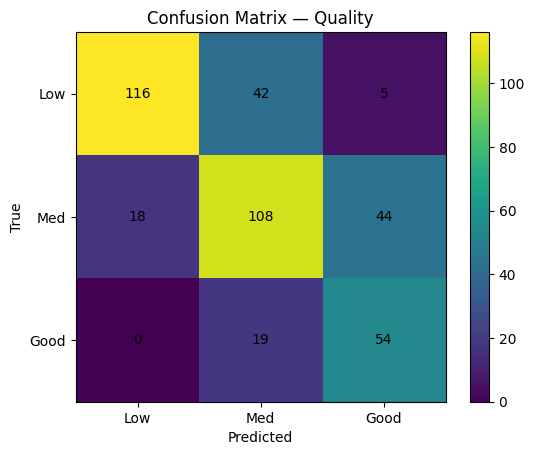

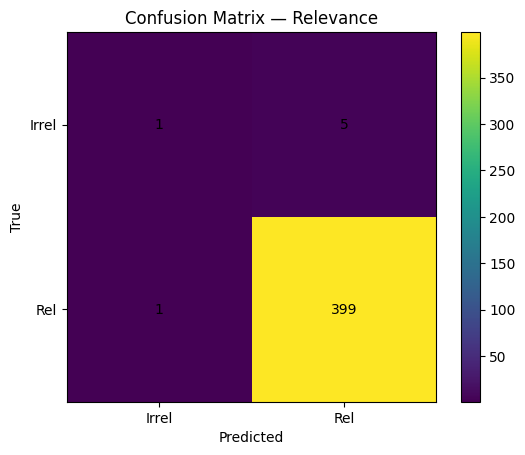

,reviewText,pred_quality,pred_relevance,uvs
1220,Okay Breakfast Spot with a Standout Dish\n\nHa...,Good,Relevant,0.692
236,"This hotel is very aesthetic, modern and has a...",Good,Relevant,0.690
4066,It was a great place; the most beautiful meatl...,Good,Relevant,0.690
2622,This is one of the classic tourist attractions...,Good,Relevant,0.687
3115,Truffle steamed buns are so delicious! The win...,Good,Relevant,0.687
129,Such an intimate and truly unique omakase expe...,Good,Relevant,0.686
2531,I have become a regular customer of this shop....,Good,Relevant,0.686
2623,The Hainanese chicken rice is absolutely delic...,Good,Relevant,0.686
2475,Attended Arsenal vs Newcastle match at this ma...,Good,Relevant,0.685
225,The Far East Organization Childrens Garden is ...,Good,Relevant,0.684


In [33]:
# Probabilities on validation set
q_probs, r_probs = predict_proba(model, tok, val_df["reviewText"].tolist(), cfg)
q_pred = q_probs.argmax(1)
r_pred = r_probs.argmax(1)

print("QUALITY (0=Low,1=Med,2=Good)")
print(classification_report(val_df["yq"], q_pred, digits=3))
print("\nRELEVANCE (0=Irrel,1=Rel)")
print(classification_report(val_df["yr"], r_pred, digits=3))

# Confusion matrices
cm_q = confusion_matrix(val_df["yq"], q_pred, labels=[0,1,2])
cm_r = confusion_matrix(val_df["yr"], r_pred, labels=[0,1])

# Plot CM: Quality
plt.figure()
plt.imshow(cm_q, interpolation="nearest")
plt.title("Confusion Matrix — Quality")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0,1,2], ["Low","Med","Good"])
plt.yticks([0,1,2], ["Low","Med","Good"])
for i in range(cm_q.shape[0]):
    for j in range(cm_q.shape[1]):
        plt.text(j, i, str(cm_q[i, j]), ha="center", va="center")
plt.colorbar()
plt.show()

# Plot CM: Relevance
plt.figure()
plt.imshow(cm_r, interpolation="nearest")
plt.title("Confusion Matrix — Relevance")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0,1], ["Irrel","Rel"])
plt.yticks([0,1], ["Irrel","Rel"])
for i in range(cm_r.shape[0]):
    for j in range(cm_r.shape[1]):
        plt.text(j, i, str(cm_r[i, j]), ha="center", va="center")
plt.colorbar()
plt.show()

# “Usefulness” score on val (for ranking)
UVS = r_probs[:,1] * (0.7*q_probs[:,2] + 0.3*q_probs[:,1])
val_view = val_df.assign(
    pred_quality=np.array(["Low","Medium","Good"])[q_pred],
    pred_relevance=np.array(["Irrelevant","Relevant"])[r_pred],
    uvs=np.round(UVS,3)
)
val_view.sort_values("uvs", ascending=False).head(10)[["reviewText","pred_quality","pred_relevance","uvs"]]


In [34]:
# Assumes: train_df, val_df, model, tok, cfg exist from your dual-head run.
# If your split isn't ready, create train_df/val_df first, with yq (0/1/2) and yr (0/1).

import numpy as np, pandas as pd, time
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from transformers import AutoTokenizer, AutoModel
import torch

# ---------- helpers ----------
def safe_auroc(y_true, y_prob):
    try:
        if len(np.unique(y_true)) < 2:
            return np.nan
        return roc_auc_score(y_true, y_prob)
    except Exception:
        return np.nan

def summarize_results(name, yq_true, yq_pred, yr_true, yr_pred, yr_prob):
    return {
        "model": name,
        "quality_macroF1": f1_score(yq_true, yq_pred, average="macro"),
        "quality_acc": accuracy_score(yq_true, yq_pred),
        "relevance_macroF1": f1_score(yr_true, yr_pred, average="macro"),
        "relevance_acc": accuracy_score(yr_true, yr_pred),
        "relevance_AUROC": safe_auroc(yr_true, yr_prob),
        "exact_match": np.mean((np.array(yq_true)==np.array(yq_pred)) & (np.array(yr_true)==np.array(yr_pred))),
    }

results = []

# ---------- 1) Majority class ----------
t0 = time.time()
maj_q = train_df["yq"].mode()[0]
maj_r = train_df["yr"].mode()[0]
yq_pred = np.full(len(val_df), maj_q)
yr_pred = np.full(len(val_df), maj_r)
yr_prob = np.full(len(val_df), 1.0 if maj_r==1 else 0.0)
results.append(summarize_results("Majority", val_df["yq"], yq_pred, val_df["yr"], yr_pred, yr_prob))
print("Majority done in", round(time.time()-t0, 2), "s")

# ---------- 2) TF-IDF → Logistic Regression ----------
t0 = time.time()
min_df = 2 if len(train_df) >= 200 else 1  # be robust on small datasets
pipe_q = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=min_df, max_df=0.95)),
    ("clf", LogisticRegression(max_iter=2000, multi_class="multinomial", class_weight="balanced"))
])
pipe_r = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=min_df, max_df=0.95)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])
pipe_q.fit(train_df["reviewText"], train_df["yq"])
pipe_r.fit(train_df["reviewText"], train_df["yr"])

yq_pred = pipe_q.predict(val_df["reviewText"])
yr_pred = pipe_r.predict(val_df["reviewText"])
yr_prob = pipe_r.predict_proba(val_df["reviewText"])[:,1]
results.append(summarize_results("TFIDF→LR", val_df["yq"], yq_pred, val_df["yr"], yr_pred, yr_prob))
print("TFIDF→LR done in", round(time.time()-t0, 2), "s")

# ---------- 3) Frozen MiniLM embeddings → Logistic Regression ----------
t0 = time.time()
ENCODER = "sentence-transformers/all-MiniLM-L6-v2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tok_f = AutoTokenizer.from_pretrained(ENCODER, use_fast=True)
mdl_f = AutoModel.from_pretrained(ENCODER).eval().to(DEVICE)

@torch.no_grad()
def mean_pool(texts, max_len=128):
    outs = []
    for i in range(0, len(texts), 64):
        batch = texts[i:i+64]
        enc = tok_f(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(DEVICE)
        last = mdl_f(**enc).last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1).float()
        sent = (last * mask).sum(1) / mask.sum(1).clamp_min(1e-9)
        outs.append(sent.cpu().numpy())
    return np.vstack(outs)

from sklearn.linear_model import LogisticRegression
Xtr = mean_pool(train_df["reviewText"].tolist(), max_len=128)
Xva = mean_pool(val_df["reviewText"].tolist(),   max_len=128)

lr_q = LogisticRegression(max_iter=2000, multi_class="multinomial", class_weight="balanced").fit(Xtr, train_df["yq"])
lr_r = LogisticRegression(max_iter=2000, class_weight="balanced").fit(Xtr, train_df["yr"])
yq_pred = lr_q.predict(Xva)
yr_pred = lr_r.predict(Xva)
yr_prob = lr_r.predict_proba(Xva)[:,1]
results.append(summarize_results("FrozenEmb→LR", val_df["yq"], yq_pred, val_df["yr"], yr_pred, yr_prob))
print("FrozenEmb→LR done in", round(time.time()-t0, 2), "s")




Majority done in 0.01 s


C:\Users\growt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


TFIDF→LR done in 0.34 s
FrozenEmb→LR done in 18.61 s


C:\Users\growt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [35]:
# ---------- 4) Your dual-head contrastive model (already trained) ----------
try:
    q_probs, r_probs = predict_proba(model, tok, val_df["reviewText"].tolist(), cfg)
    yq_pred = q_probs.argmax(1)
    yr_pred = r_probs.argmax(1)
    yr_prob = r_probs[:,1]
    results.append(summarize_results("Contrastive MTL (yours)", val_df["yq"], yq_pred, val_df["yr"], yr_pred, yr_prob))
    print("Contrastive MTL evaluated.")
except Exception as e:
    print("⚠️ Skipping MTL comparison (could not access model/tok/cfg):", e)

# ---------- Final results table ----------
res_df = pd.DataFrame(results).round(3)
display(res_df.sort_values(["quality_macroF1","relevance_macroF1"], ascending=False))

Contrastive MTL evaluated.


,model,quality_macroF1,quality_acc,relevance_macroF1,relevance_acc,relevance_AUROC,exact_match
3,Contrastive MTL (yours),0.677,0.685,0.621,0.985,0.820,0.672
2,FrozenEmb→LR,0.646,0.653,0.539,0.956,0.782,0.616
1,TFIDF→LR,0.645,0.660,0.494,0.978,0.742,0.643
0,Majority,0.197,0.419,0.496,0.985,0.500,0.419


Best baseline: FrozenEmb→LR


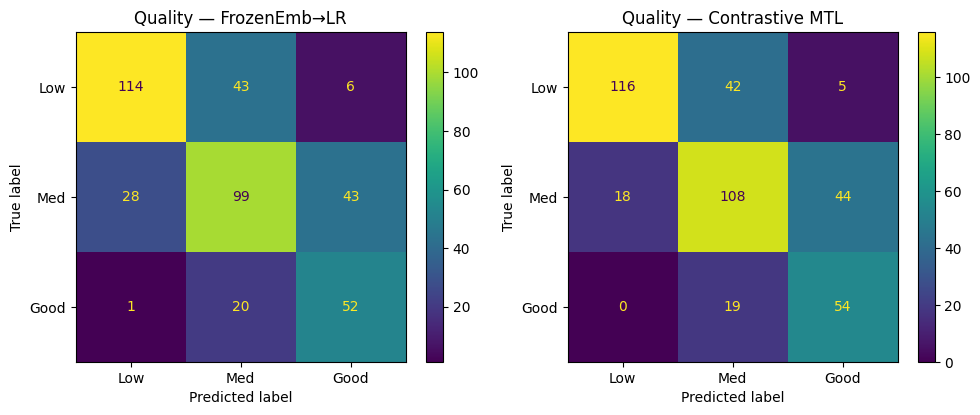

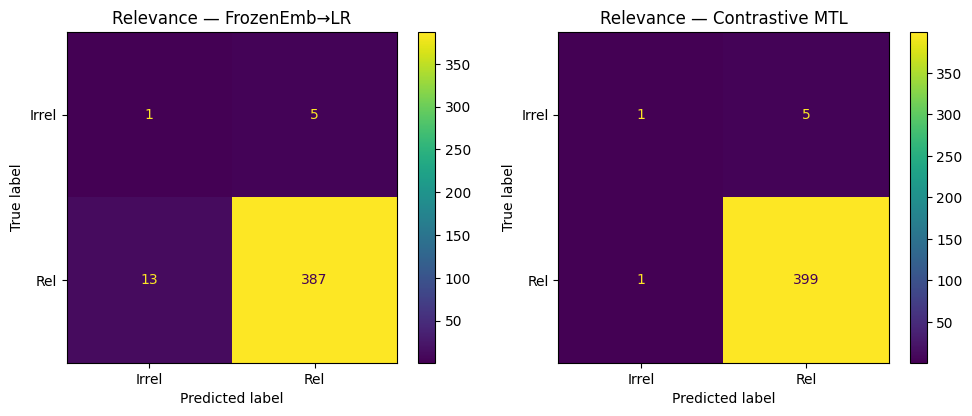

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Identify best baseline by average of macro-F1s (exclude your model in the pick)
is_mtl = res_df["model"].str.contains("Contrastive", case=False, na=False)
baselines_only = res_df.loc[~is_mtl]
best_base = baselines_only.assign(avgF1 = (baselines_only["quality_macroF1"] + baselines_only["relevance_macroF1"])/2) \
                           .sort_values("avgF1", ascending=False)["model"].iloc[0]
print("Best baseline:", best_base)

# Recompute predictions for that baseline (so we can plot CMs)
if best_base == "TFIDF→LR":
    yq_pred_b = pipe_q.predict(val_df["reviewText"])
    yr_pred_b = pipe_r.predict(val_df["reviewText"])
elif best_base == "FrozenEmb→LR":
    yq_pred_b = lr_q.predict(Xva)
    yr_pred_b = lr_r.predict(Xva)
else:  # Majority
    yq_pred_b = np.full(len(val_df), maj_q)
    yr_pred_b = np.full(len(val_df), maj_r)

# Your model predictions (if available)
try:
    yq_pred_m = q_probs.argmax(1)
    yr_pred_m = r_probs.argmax(1)
except NameError:
    yq_pred_m = yq_pred_b  # fallback to baseline to avoid crash
    yr_pred_m = yr_pred_b

# Plot CMs: Quality
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(val_df["yq"], yq_pred_b, labels=[0,1,2], display_labels=["Low","Med","Good"], ax=axes[0])
axes[0].set_title(f"Quality — {best_base}")
ConfusionMatrixDisplay.from_predictions(val_df["yq"], yq_pred_m, labels=[0,1,2], display_labels=["Low","Med","Good"], ax=axes[1])
axes[1].set_title("Quality — Contrastive MTL")
plt.tight_layout()
plt.show()

# Plot CMs: Relevance
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(val_df["yr"], yr_pred_b, labels=[0,1], display_labels=["Irrel","Rel"], ax=axes[0])
axes[0].set_title(f"Relevance — {best_base}")
ConfusionMatrixDisplay.from_predictions(val_df["yr"], yr_pred_m, labels=[0,1], display_labels=["Irrel","Rel"], ax=axes[1])
axes[1].set_title("Relevance — Contrastive MTL")
plt.tight_layout()
plt.show()


In [37]:
import os, glob
from huggingface_hub import snapshot_download


# Download a small, free quantized model (CPU-friendly)
repo_id = "microsoft/Phi-3-mini-4k-instruct-gguf"
local_dir = snapshot_download(repo_id=repo_id, allow_patterns=["*.gguf"])
# Pick a Q4 file (balance of speed/quality)
ggufs = sorted(glob.glob(os.path.join(local_dir, "*q4*.gguf"))) or sorted(glob.glob(os.path.join(local_dir, "*.gguf")))
assert ggufs, "No GGUF files found; open the repo and pick a file ending with q4.gguf"
model_path = ggufs[0]
model_path



Fetching 2 files: 100%|██████████| 2/2 [00:00<?, ?it/s]


'C:\\Users\\growt\\.cache\\huggingface\\hub\\models--microsoft--Phi-3-mini-4k-instruct-gguf\\snapshots\\999f761fe19e26cf1a339a5ec5f9f201301cbb83\\Phi-3-mini-4k-instruct-q4.gguf'

In [38]:
import json, re
from tqdm import tqdm
import numpy as np

CLASS_MAP_QUALITY = {"low":0, "medium":1, "med":1, "good":2}
CLASS_MAP_REL = {"irrelevant":0, "relevant":1}

SYSTEM = (
"You are a strict classifier. "
"Output ONLY a compact JSON object with fields: "
'{"quality": "Low|Medium|Good", "relevance": "Irrelevant|Relevant", '
'"confidence_quality": number 0..1, "confidence_relevance": number 0..1}. '
"No extra text."
)

USER_TMPL = (
"Classify the following review for (1) quality for readers and (2) relevance to the location. "
"Definitions:\n"
"- Quality=Good: specific, actionable details (price/time/wait/items/service), balanced; "
"Medium: some useful info but limited specifics; Low: vague or spammy.\n"
"- Relevance: whether it actually talks about the named place or its experience.\n\n"
"Review: \"{text}\""
)

def parse_first_json(s: str):
    # get first {...} and parse; fallback to empty
    m = re.search(r"\{.*\}", s, flags=re.S)
    if not m: 
        return {}
    try:
        return json.loads(m.group(0))
    except Exception:
        # try to fix common issues (single quotes, trailing commas)
        s2 = m.group(0).replace("'", '"')
        s2 = re.sub(r",\s*}", "}", s2)
        s2 = re.sub(r",\s*]", "]", s2)
        try:
            return json.loads(s2)
        except Exception:
            return {}

def classify_batch(texts):
    preds = []
    for t in tqdm(texts, desc="LLM classify"):
        prompt = [
            {"role":"system", "content": SYSTEM},
            {"role":"user", "content": USER_TMPL.format(text=t.strip()[:1200])}
        ]
        out = llm.create_chat_completion(messages=prompt, temperature=0.0, max_tokens=64)
        content = out["choices"][0]["message"]["content"]
        js = parse_first_json(content)
        q = str(js.get("quality","")).strip().lower()
        r = str(js.get("relevance","")).strip().lower()
        cq = float(js.get("confidence_quality", 0.5)) if str(js.get("confidence_quality","")).strip() != "" else 0.5
        cr = float(js.get("confidence_relevance", 0.5)) if str(js.get("confidence_relevance","")).strip() != "" else 0.5
        yq_hat = CLASS_MAP_QUALITY.get(q, 1)  # default Medium
        yr_hat = CLASS_MAP_REL.get(r, 1)      # default Relevant
        preds.append((yq_hat, yr_hat, cr))
    yq_pred = np.array([p[0] for p in preds])
    yr_pred = np.array([p[1] for p in preds])
    yr_prob = np.array([p[2] for p in preds])  # pseudo-prob from confidence_relevance
    return yq_pred, yr_pred, yr_prob


In [39]:
from llama_cpp import Llama
import os
N_THREADS = max(2, os.cpu_count() or 4)
llm = Llama(
    model_path=model_path,
    n_ctx=2048,
    n_threads=N_THREADS,
    # set n_gpu_layers>0 if you have a GPU and built llama-cpp with CUDA/Metal
    n_gpu_layers=0
)


llama_model_loader: loaded meta data with 24 key-value pairs and 195 tensors from C:\Users\growt\.cache\huggingface\hub\models--microsoft--Phi-3-mini-4k-instruct-gguf\snapshots\999f761fe19e26cf1a339a5ec5f9f201301cbb83\Phi-3-mini-4k-instruct-q4.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = phi3
llama_model_loader: - kv   1:                               general.name str              = Phi3
llama_model_loader: - kv   2:                        phi3.context_length u32              = 4096
llama_model_loader: - kv   3:                      phi3.embedding_length u32              = 3072
llama_model_loader: - kv   4:                   phi3.feed_forward_length u32              = 8192
llama_model_loader: - kv   5:                           phi3.block_count u32              = 32
llama_model_loader: - kv   6:                 